# TP1 : Algorithme EM et modèle de mélange gaussien

## Introduction à l'estimation statistique - G3 SDIA

L'objectif de ce TP est d'implémenter l'algorithme EM pour estimer par maximum de vraisemblance les paramètres d'un modèle de mélange gaussien.

On utilisera le dataset *Old Faithful*, qui décrit 272 éruptions du geyser appelé Old Faithful du parc national de Yellowstone aux États-Unis. Chaque observation est constituée de 2 variables : le temps d'attente avant l'éruption (en minutes) et la durée de l'éruption (en minutes).

### Instructions

1. Renommer votre notebook sous la forme `tp1_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 15 Octobre 2023, 23h59.

In [12]:
# Import necessary libraries
import numpy as np
import scipy.stats as ss
import seaborn
from matplotlib import pyplot as plt

**Q1**. Charger le dataset, normaliser puis visualiser les données. Commenter.

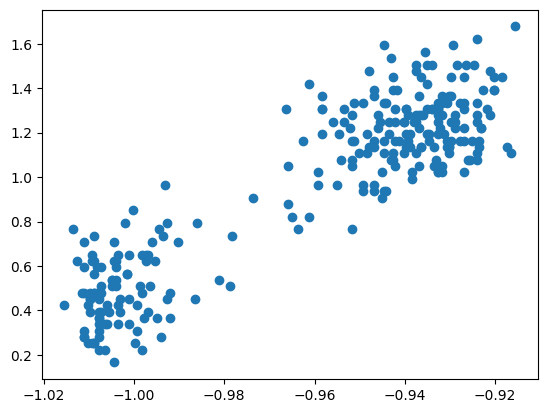

In [13]:
import pandas as pd
import io
import requests

# Téléchargez le fichier CSV manuellement depuis le lien Seaborn
url = "https://github.com/mwaskom/seaborn-data/raw/master/geyser.csv"
response = requests.get(url)
data = io.StringIO(response.text)
# Chargez les données à partir du fichier local
df = pd.read_csv(data)

X = df[['duration', 'waiting']].values
N, D = X. shape

# Standardize data to avoid numerical instabilities
standardize = lambda vec : (vec - np.mean(vec))/np.std(vec)
X = standardize(X)

duration = X[:,0]
waiting = X[:,1]
# Show data
plt.scatter(duration, waiting)
plt.show()


----- Votre réponse ici -----








**Q2**. On note $\mathbf{x}_1,...,\mathbf{x}_n$ les données. On souhaite les modéliser par un modèle de mélange gaussien à $K$ composantes.

Écrire une fonction permettant de calculer la log-vraisemblance :
$$ \log \mathcal{L}(\theta;\mathbf{x}_1,...,\mathbf{x}_n) = \sum_{i=1}^n \log \left( \sum_{k=1}^K \pi_k \frac{1}{2 \pi \text{det}(\boldsymbol{\Sigma}_k)^{1/2}} \exp \left( \frac{1}{2} (\mathbf{x}_i - \boldsymbol{\mu}_k)^{\top} \boldsymbol{\Sigma}_k^{-1} (\mathbf{x}_i - \boldsymbol{\mu}_k) \right) \right), $$
avec $\theta = \{ \boldsymbol{\mu_1}, ..., \boldsymbol{\mu_k}, \boldsymbol{\Sigma}_1, ..., \boldsymbol{\Sigma}_k, \pi_1, ..., \pi_k \}$.

On pourra utiliser la fonction $\texttt{multivariate} \_ \texttt{normal.pdf}$ de la librairie scipy.stats.

In [29]:
def log_likelihood(theta, X, K): # Fill in the appropriate arguments
    """
    This function calculates the log_likelihood of an input matrix X.

        params: 
            K: is the number of hyperparameters of our model
            X: is the input matrix
            theta: 
                theta[0] is the K mu vectors
                theta[1] are the K covariance matrix
                theta[2] are the K pi weights of the sum
    """
    total_sum = 0
    for i in range (N):
        intern_sum = 0
        for k in range(K):
            intern_sum += theta[2][k] * ss.multivariate_normal.pdf(X[i,:], mean=theta[0][k], cov=theta[1][k])
        total_sum += np.log(intern_sum)
    
    return total_sum
    # # # # # # # # #
    # YOUR CODE HERE #
    # # # # # # # # #

"""
log_likelihood(
    [
        [[2.1,0.9],[0.9,0.8]],
        [[[1,0],[0,1]],[[1,0],[0,1]]],
        [0.5,0.5]
    ],
    X,
    2
)
"""

'\nlog_likelihood(\n    [\n        [[2.1,0.9],[0.9,0.8]],\n        [[[1,0],[0,1]],[[1,0],[0,1]]],\n        [0.5,0.5]\n    ],\n    X,\n    2\n)\n'

**Q3**. Écrire une fonction qui implémente l'algorithme EM dans ce modèle, prenant pour arguments les données, le nombre de composantes $K$, et le nombre d'itérations de l'algorithme $N_{\text{iter}}$. Cette fonction retournera un tableau de taille $N_{\text{iter}} + 1$ contenant l'évolution des valeurs de la log-vraisemblance, ainsi que les valeurs finales des paramètres.

Initialisation des paramètres :
- Pour les moyennes, les $K$ premières observations du dataset ;
- Pour les matrices de covariances, la matrice identité ;
- $\pi_k = 1/K$.

In [15]:
from copy import deepcopy
def EM_algorithm_v1(X, K, Niter):
    N, D = X. shape
    
    # Initialize parameters
    theta = [
        X[:K,:],
        [np.identity(D) for _ in range(K)],
        [1/K for _ in range(K)]
    ]

    output_theta = []
    # # # # # # # # #
    # YOUR CODE HERE #
    # # # # # # # # #

    for _ in range(0,Niter):
        # E-STEP
        r_n_k = np.array([[theta[2][k] *  ss.multivariate_normal.pdf(X[l,:], mean=theta[0][k], cov=theta[1][k]) for k in range(K)] for l in range(N)])
        r_n_k = np.array([ r_n_k[l,:] / sum(r_n_k[l,:]) for l in range(N)])
        # # # # # # # # #
        # YOUR CODE HERE #
        # # # # # # # # #
        
        # M-STEP
        for k in range(K):

            theta[0][k] = np.array( np.sum(np.array([ r_n_k[l,k] * X[l,:] for l in range(N) ]), axis=0) / np.sum(r_n_k[:,k]) )
            
            first_term = np.sum(np.array([ r_n_k[l,k] * np.outer(X[l,:],X[l,:]) for l in range(N) ]), axis=0) / np.sum(r_n_k[:,k])
            second_term = np.outer(theta[0][k],theta[0][k])

            theta[1][k] = first_term - second_term

            theta[2][k] = 1/N * np.sum( r_n_k[:,k] )

        output_theta.append(deepcopy(theta))
        # # # # # # # # #
        # YOUR CODE HERE #
        # # # # # # # # #

    return output_theta # YOUR CODE HERE #


**Q4**. Faire tourner l'algorithme avec $K = 2$ et $N_{\text{iter}} = 50$.

Afficher l'évolution de la log-vraisemblance en fonction des itérations. Commenter.

Sur une même figure, afficher le dataset et représenter les estimations des deux lois normales du mélange à l'aide d'un *contour plot*. On pourra utiliser la fonction $\texttt{plt.contour}$.

[array([[-0.95746642,  1.01392721],
       [-0.96577281,  0.90462563]]), [array([[0.00112251, 0.01108753],
       [0.01108753, 0.13681067]]), array([[0.00078607, 0.01023637],
       [0.01023637, 0.15803315]])], [0.5190003172493346, 0.4809996827506654]]
[array([[-0.95746642,  1.01392721],
       [-0.96577281,  0.90462563]]), [array([[0.00112251, 0.01108753],
       [0.01108753, 0.13681067]]), array([[0.00078607, 0.01023637],
       [0.01023637, 0.15803315]])], [0.5190003172493346, 0.4809996827506654]]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 180 and the array at index 1 has size 12

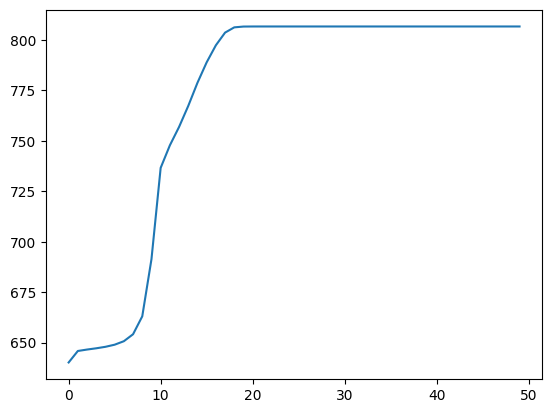

In [30]:
K = 2
Niter = 50

thetas = EM_algorithm_v1(X, 2, 50)

x = np.array([k for k in range(Niter)])
y = np.array([log_likelihood(theta, X, K) for theta in thetas])
#print(y)

plt.plot(x,y)


y_min, y_max = -1.02, -0.9  # Adjust the range as needed
x_min, x_max = 0, 1.8  # Adjust the range as needed
step = 0.01  # Adjust the step size as needed
x = np.arange(x_min, x_max, step)
y = np.arange(y_min, y_max, step)
Xgrid, Ygrid = np.meshgrid(x, y)


pos = np.dstack((x, y))
pdf_values = ss.multivariate_normal(thetas[-1][0][0], thetas[-1][1][0]).pdf(pos)

print(pdf_values.shape)

plt.scatter(X[:, 0], X[:, 1], alpha=1)
for theta in thetas:
    for k in range(K):
        mean = theta[0][k]
        cov = theta[1][k]
        plt.contour(
            x,
            y,
            pdf_values(),
            cmap='viridis'
        )
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Contour Plots of Estimated Normal Distributions')


plt.show()


# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #

----- Votre réponse ici -----

**Q5**. On souhaite maintenant étudier l'influence de l'initialisation sur les résultats. Modifier la fonction implémentant l'algorithme EM en y rajoutant un argument pour la graine aléatoire. Les paramètres seront maintenant initialisés de la manière suivante :
- $\boldsymbol{\mu}_k \sim \mathcal{N}(\mathbf{0},\mathbf{I}_2)$ ;
- $[\pi_1, ..., \pi_K]^{\top} \sim \text{Dirichlet}([1, ..., 1]^{\top})$ ;
- On gardera l'initialisation des matrices de covariance à la matrice identité.

In [ ]:
def EM_algorithm_v2(X, K, Niter, seed):
    N, D = X. shape
    
    # Initialize parameters
    np.random.seed(seed)

    # # # # # # # # #
    # YOUR CODE HERE #
    # # # # # # # # #

    for i in range(0,Niter):
        # E-STEP
        
        # # # # # # # # #
        # YOUR CODE HERE #
        # # # # # # # # #
        
        # M-STEP
        
        # # # # # # # # #
        # YOUR CODE HERE #
        # # # # # # # # #
        
    return # YOUR CODE HERE #

IndentationError: expected an indented block after 'for' statement on line 11 (1666574397.py, line 24)

**Q6**. On choisit maintenant $K=3$. Représenter l'évolution de la log-vraisemblance pour 10 graines aléatoires différentes. Commenter.

Afficher deux cas où la solution retournée par l'algorithme EM est visuellement différente. Commenter.

Quelle estimation de paramètres doit-on choisir ?

In [ ]:
K = 3

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #


----- Votre réponse ici -----

**Q7**. On cherche maintenant à choisir la valeur optimale de $K$. Pour cela, on aimerait pouvoir comparer la vraisemblance des modèles obtenus avec différentes valeurs de $K$.

Cela peut se faire au travers d'un critère de sélection de modèle. Dans ce TP, nous étudierons le critère dit BIC :
$$ \text{BIC}(m) = k(m) \log(n) - 2 \log \mathcal{L}(m),$$
où $m$ est un modèle (ici donné par une valeur de $K$), $k_m$ est le nombre de paramètres libres dans le modèle, $n$ le nombre d'échantillons, et $\mathcal{L}_m$ le maximum de la fonction de vraisemblance de le modèle $m$. On sélectionne le modèle avec le plus faible BIC.

Montrer que $$k(m) = \frac{K}{2} (D+1)(D+2) - 1.$$

Comparer les valeurs de $K$ allant de 1 à 6. Quel est le modèle optimal d'après le critère BIC ?

In [ ]:
# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #


----- Votre réponse ici -----

**Question bonus**. Expliquer comment l'algorithme EM peut-être utilisé pour du clustering.


----- Votre réponse ici -----